# Full Code For Ocean Stommel Project

## Non-Dimensionalized Code:

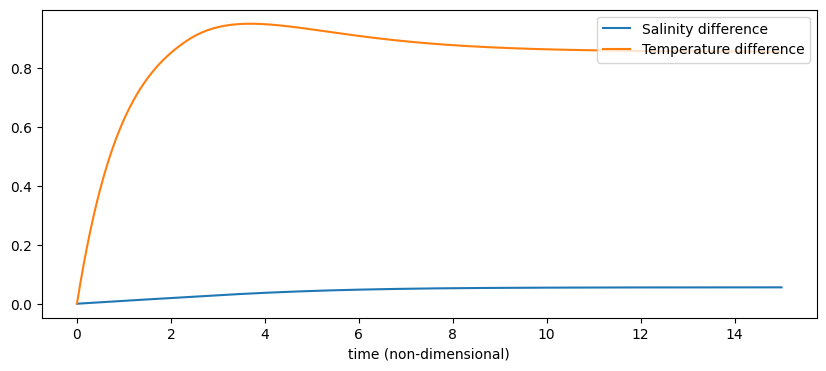

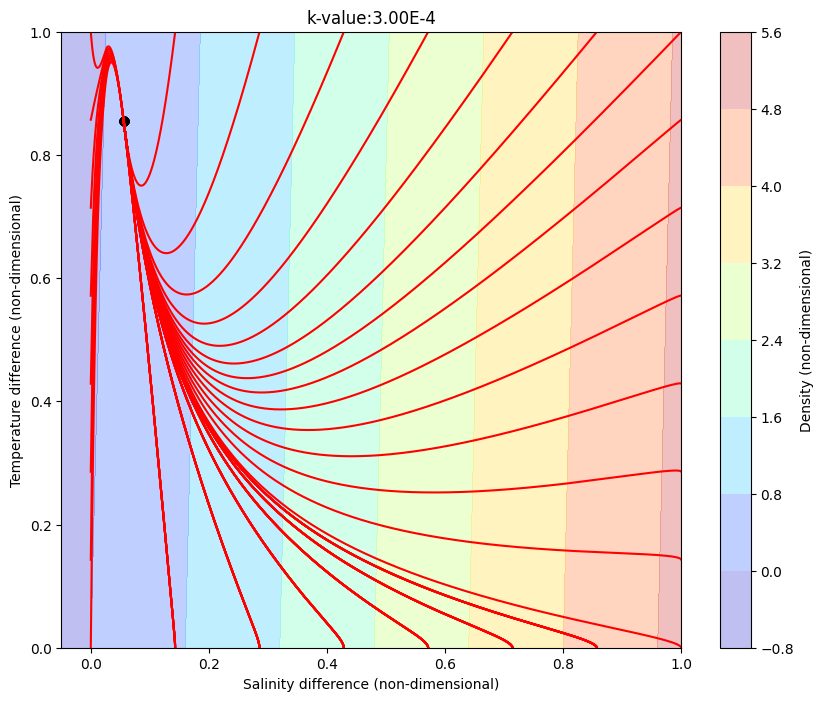

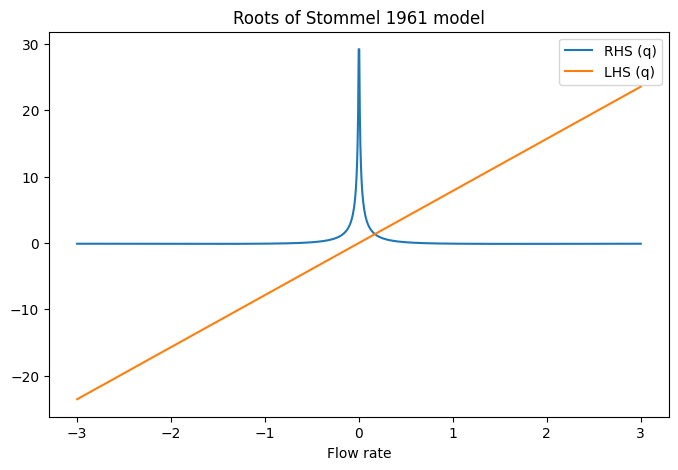

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
nn = 0  # flag


c = 1   # characteristic timescale of 1e8 [s]
d = 1e-2
alpha = 9.545e-6
beta = 3.75e-4

k = 3e-4  # in range of 1e-2 to 1e-5 lead to stable solutions


rho0 = 1.0
delta = d / c

# simulation parameters
nstep = 15000
dtau = 0.001
delT = 1 / 8
delS = delT

# initialize arrays
x = np.zeros(nstep)
y = np.zeros(nstep)
tau = np.zeros(nstep)

# other parameters
R = beta / alpha
lambda1 = (c * k) / (4 * rho0 * alpha)

# initial conditions and other constants
q = 0.0
qdelta = 100.0
yres = 1.0

F = 0   # Greenland freshwater flux
dF = 3e-8

# simulation loop
for n1 in np.linspace(0, 1, num=int(1 / delT)):
    for n2 in np.linspace(0, 1, num=int(1 / delS)):
        if n1 == 0 or n1 == 1 or n2 == 0 or n2 == 1:
            x[0] = n1
            y[0] = n2
            for m in range(1,nstep):
                tau[m] = m * dtau
                dr = abs(R * x[m - 1] - y[m - 1])
                qequil = dr / lambda1
                yh = y[m - 1] + dtau * (yres - y[m - 1]) / 2 - dtau * y[m - 1] * q / 2
                xh = x[m - 1] + dtau * delta * (1 - x[m - 1]) / 2 - dtau * x[m - 1] * q / 2
                qh = q + dtau * qdelta * (qequil - q) / 2
                dr = abs(R * xh - yh)
                qequil = dr / lambda1
                
                #F += m * dtau * dF
                y[m] = y[m - 1] + dtau * (yres - yh) - dtau * qh * yh
                x[m] = x[m - 1] + dtau * delta * (1 - xh) - dtau * qh * xh - dtau * F # plus greenland term
                q = q + dtau * qdelta * (qequil - qh)


        d = R*x  - y   #  evaluate the density

        if nn==0:   #make a time series plot of the first case only 
            nn=1 #change flag
            # plotting
            plt.figure(figsize=(10, 4))
            plt.plot(tau, x, label='Salinity difference')
            plt.plot(tau, y, label='Temperature difference')
            plt.xlabel('time (non-dimensional)')
            plt.legend(loc='upper right')

            plt.figure(figsize=(10, 8))
            xm = np.linspace(-0.05, 1, 10)
            ym = np.linspace(-0., 1, 10)
            dm = np.zeros((10, 10))
            for i in range(10):
                for j in range(10):
                    dm[i, j] = (1 / lambda1) * (R * xm[j] - ym[i])
            plt.contourf(xm, ym, dm, alpha=0.25, cmap='jet')
            plt.colorbar(label='Density (non-dimensional)')
            plt.xlabel('Salinity difference (non-dimensional)')
            plt.ylabel('Temperature difference (non-dimensional)')
            plt.title(f'k-value:{Decimal(k):.2E}')

        if d[-1] >= 0:
            plt.plot(x, y, c='r')
            plt.scatter(x[-1], y[-1], c='k')
        else:
            pass
            plt.plot(x, y, c='blue')
            plt.scatter(x[-1], y[-1], c='k')


nk = 1000
f = np.linspace(-3, 3, nk)
lhs = np.zeros(nk)
rhs = np.zeros(nk)
for i in range(nk):
    lhs[i] = lambda1 * f[i]
    rhs[i] = (R / (1 + abs(f[i]) / delta)) - 1 / (1 + abs(f[i]))
plt.figure(figsize=(8, 5))
plt.plot(f, rhs, label='RHS (q)')
plt.plot(f, lhs, label='LHS (q)')
plt.xlabel('Flow rate')
plt.legend()
plt.title('Roots of Stommel 1961 model')

plt.show()

## Dimensionalized Code:

m = 0
m = 1e-08
m = 1e-07


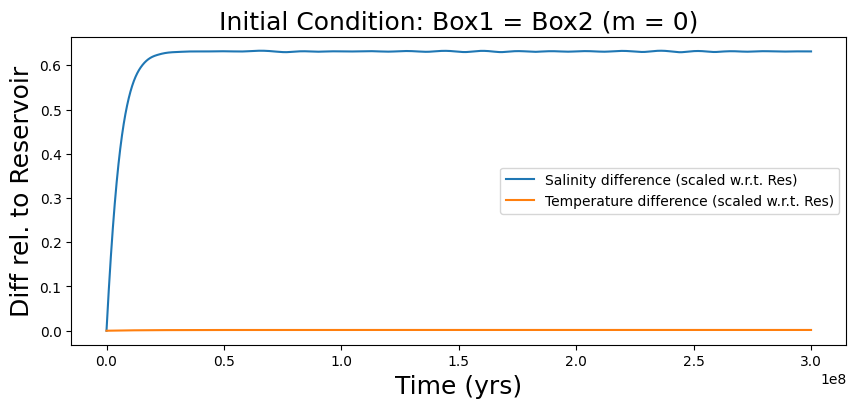

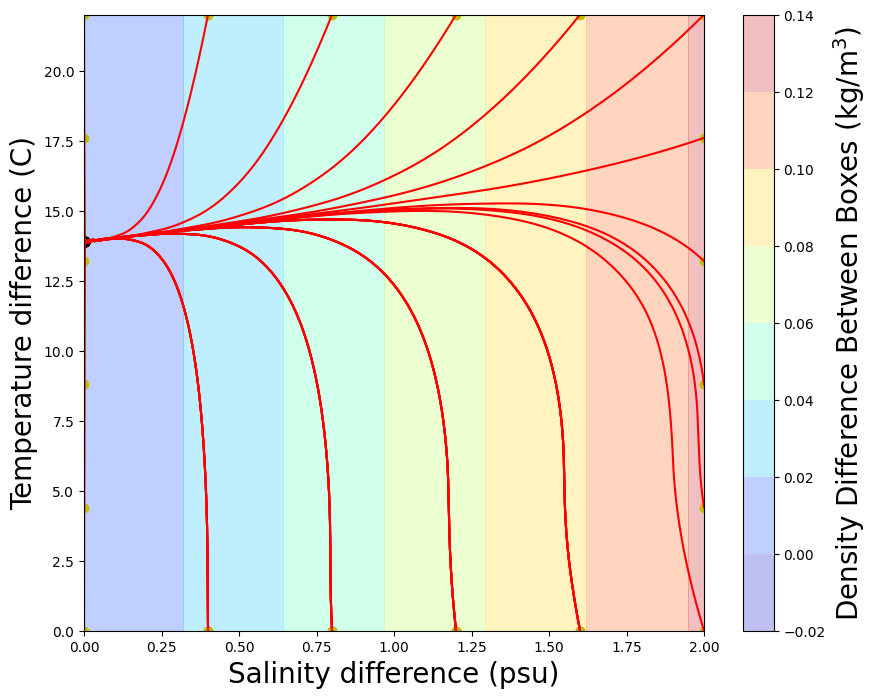

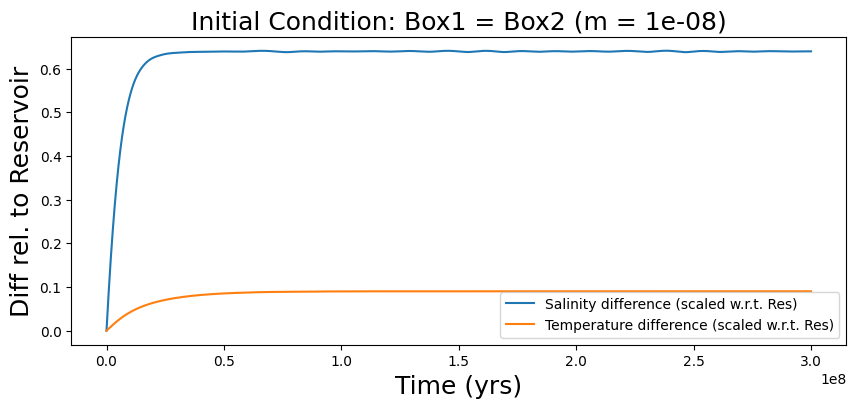

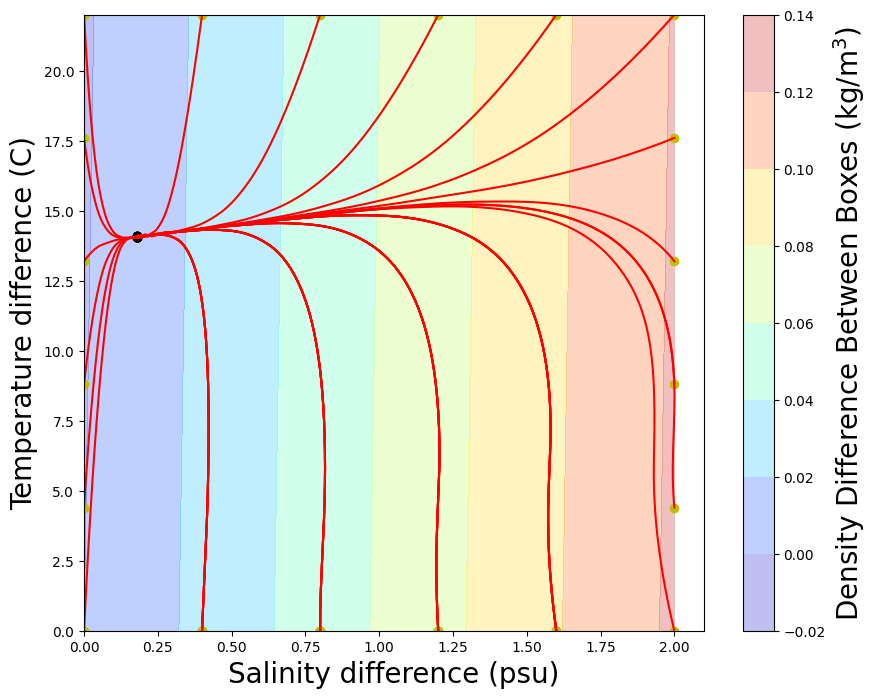

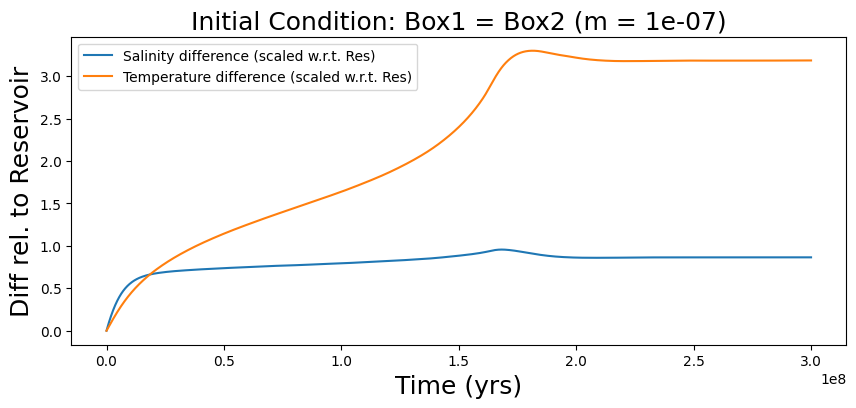

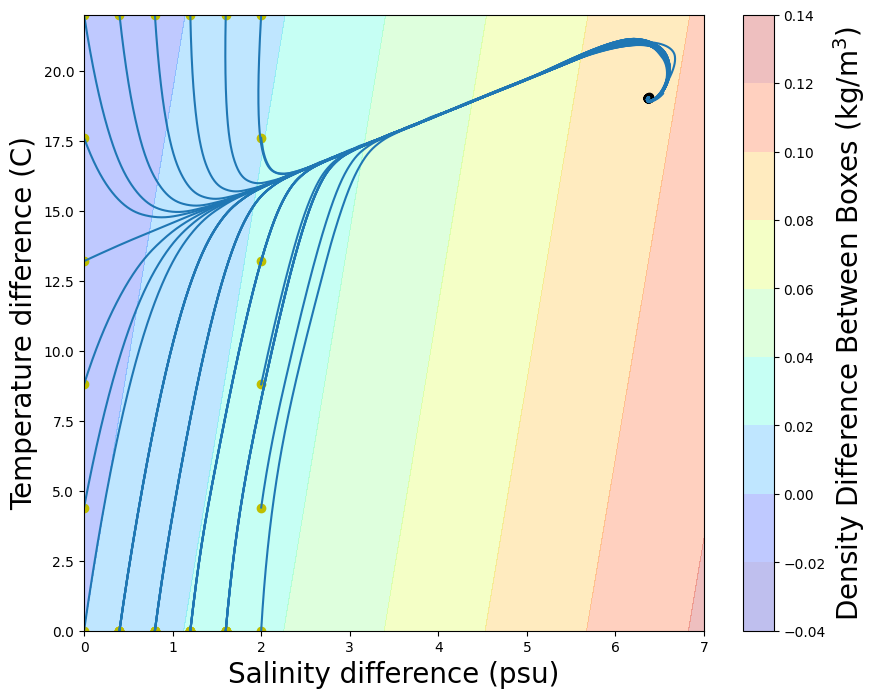

<Figure size 1000x800 with 0 Axes>

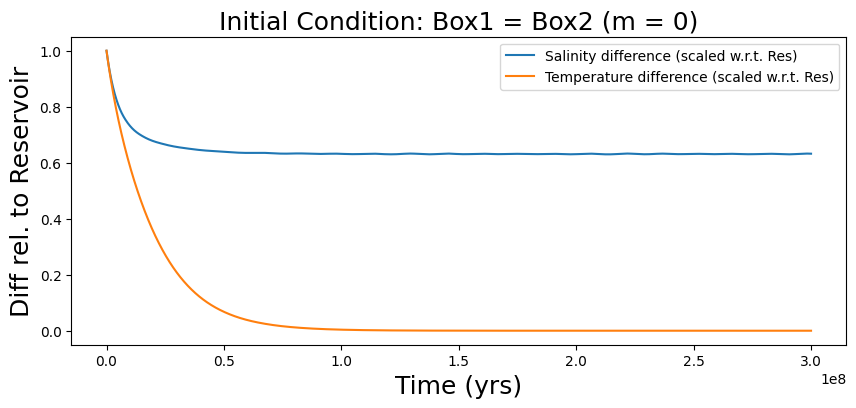

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# Set dimensionalized parameters
alpha = 2.1e-4
beta = 7.5e-4
c = 1e-7
d = 1e-10
kappa = 1e8
T1_res = 28
T2_res = 6
S1_res = 36.5
S2_res = 34.5
rho_0 = 1000 
m_vec = [0, 1e-8, 1e-7] #the 3 possible values of m

# Initialize time
t0 = 0
t_end = 300000000
t_span = (t0, t_end)
num_points = 10000 
t_eval = np.linspace(t0, t_end, num_points)

def odesystem(t, y, T1_res, T2_res, S1_res, S2_res, c, d, alpha, beta, rho_0, kappa,  m=0):
    '''
    Solves the ODE system outline in the Dimensionalized Section
    m here is an optional paramter describing the incoming salinity freen Greenland's glaciers
    Also box 1 denotes hot, 2 is cold
    '''
    T1, T2, S1, S2 = y

    q = (rho_0/kappa)* ((1 - alpha * T1 + beta * S1) - (1 - alpha * T2 + beta * S2))
    dT1_dt = c * (T1_res - T1) - (T1 - T2) * np.abs(q)
    dT2_dt = c * (T2_res - T2) - (T2 - T1) * np.abs(q) 
    dS1_dt = d * (S1_res - S1) - (S1 - S2) * np.abs(q)
    dS2_dt = d * (S2_res - S2) - (S2 - S1) * np.abs(q) - m
    
    return [dT1_dt, dT2_dt, dS1_dt, dS2_dt]




int_steps = 6
nn = 0 # flag for contour plot


for m in m_vec:
    print('m =', m)

    for n1 in np.linspace(0,1,num=int_steps): #n1 and n2 are used to set the initial T,S

        for n2 in np.linspace(0,1,num=int_steps):

                # checks for boundary condition
                if (n1==0 or n1==1 or n2==0 or n2==1): 

                    #sets initial values
                    initial_S1  = (1/2 + n1/2)*S1_res + (1/2 - n1/2) *S2_res
                    initial_S2  = (1/2 + n1/2)*S2_res + (1/2 - n1/2)*S1_res 
                    initial_T1  = (1/2 + n2/2)*T1_res + (1/2 - n2/2)*T2_res  
                    initial_T2  = (1/2 + n2/2)*T2_res + (1/2 - n2/2)*T1_res     
                    initial_conditions = [initial_T1, initial_T2, initial_S1, initial_S2]

                    # find solutions
                    solution = solve_ivp(odesystem, t_span, initial_conditions, args=(T1_res, T2_res, S1_res, S2_res, c, d, alpha, beta, rho_0, kappa, m), t_eval=t_eval)
                    T1_values, T2_values, S1_values, S2_values = solution.y
                    t_values = solution.t

                    T_diff = T1_values - T2_values
                    S_diff = S1_values - S2_values
                    initial_den_diff =  (rho_0 * (1 - alpha * T2_values[0] + beta * S2_values[0]) - rho_0 * (1 - alpha * T1_values[0] + beta * S1_values[0]))
                    dens_diff =  (rho_0 * (1 - alpha * T2_values + beta * S2_values) - rho_0 * (1 - alpha * T1_values + beta * S1_values))


                if (n1 == 0 and n2 == 0):
                    # Graph the Time dependent plot like in Figure 8 for the iniital codition Box1 = Box2
                    plt.figure(figsize=(10,4))
                    plt.plot(t_values, T_diff/(T1_res - T2_res), label='Salinity difference (scaled w.r.t. Res)')
                    plt.plot(t_values, S_diff/(S1_res - S2_res) , label='Temperature difference (scaled w.r.t. Res)')
                    plt.xlabel('Time (yrs)', fontsize=18)
                    plt.ylabel('Diff rel. to Reservoir', fontsize=18)
                    plt.title(f'Initial Condition: Box1 = Box2 (m = {m})', fontsize=18)
                    plt.legend()
                    plt.savefig('dimen_noise_time.pdf')                

                    nn = 1

                    nm=10
                    # have to manually set contour plot if m > 1e-8
                    if (m > 1e-8):
                        xm=np.linspace(0,7,nm)
                    else:
                        xm = np.linspace(0, S1_res - S2_res, nm)
                    ym=np.linspace(0,T1_res - T2_res,nm)
                    dm=np.zeros((nm,nm))

                    # calculate contour densities
                    for k1 in range(nm):
                        for k2 in range(nm):
                            dm[k1, k2] = (rho_0 * (1 - alpha * T2_values[k2] + beta * S2_values[k1]) - rho_0 * (1 - alpha * T1_values[k2] + beta * S1_values[k1]))

                    # Create the contour plot
                    plt.figure(figsize=(10,8))
                    contour = plt.contourf(xm, ym, dm, alpha=0.25, cmap='jet')
                    colorbar = plt.colorbar(contour)
                    colorbar.set_label(r'Density Difference Between Boxes (kg/m$^3$)', fontsize=20)
                    colorbar.ax.yaxis.label.set_fontsize(20)  # Increase the colorbar label fontsize
                    plt.xlabel(r'Salinity difference (psu)', fontsize=20)
                    plt.ylabel(r'Temperature difference (C)', fontsize=20)

                # Temperature Driven
                if dens_diff[-1]>=0:
                    plt.plot(S_diff,T_diff,c='r')
                    plt.scatter(S_diff[0],T_diff[0],c='y')
                    plt.scatter(S_diff[-1],T_diff[-1],c='k')

                # Salinity Driven
                else:
                    plt.plot(S_diff,T_diff,c='tab:blue')
                    plt.scatter(S_diff[0],T_diff[0],c='y')
                    plt.scatter(S_diff[-1],T_diff[-1],c='k')                 



# There is also a single plot Figure 8a that is not plotted in the above for loop:
initial_S1  = S1_res
initial_S2  = S2_res
initial_T1  = T1_res 
initial_T2  = T2_res 
m = 0
solution = solve_ivp(odesystem, t_span, initial_conditions, args=(T1_res, T2_res, S1_res, S2_res, c, d, alpha, beta, rho_0, kappa, m), t_eval=t_eval)
T1_values, T2_values, S1_values, S2_values = solution.y
t_values = solution.t

T_diff = T1_values - T2_values
S_diff = S1_values - S2_values

plt.figure(figsize=(10, 8))
plt.figure(figsize=(10,4))
plt.plot(t_values, T_diff/(T1_res - T2_res), label='Salinity difference (scaled w.r.t. Res)')
plt.plot(t_values, S_diff/(S1_res - S2_res) , label='Temperature difference (scaled w.r.t. Res)')
plt.xlabel('Time (yrs)', fontsize=18)
plt.ylabel('Diff rel. to Reservoir', fontsize=18)
plt.title(f'Initial Condition: Box1 = Box2 (m = {m})', fontsize=18)

plt.legend()